nf1之前 0.55左右

In [1]:
import sys
sys.path.append('./app/')
import numpy as np
import fileio
import evaluation
import preprocess
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
fileio.read_all??

In [3]:
dfoff ,dftest,dfon = fileio.read_all()

In [3]:
# 预处理，部分特征处理
dfoff,weekdaycols = preprocess.preprocess(dfoff)
dftest,weekdaycols = preprocess.preprocess(dftest)
# 分割测试子集和训练子集
x_train,y_train,x_test,y_test,train,valid = preprocess.split_t_v(dfoff,weekdaycols)

In [3]:
#xgb 和 LGD
import xgboost as xgb
from sklearn.linear_model import SGDClassifier

# 1.普选

In [4]:
# 模型一
model_sgd = SGDClassifier(loss='log',penalty='elasticnet',fit_intercept=True,max_iter=100,
                      shuffle=True,alpha = 0.01,l1_ratio = 0.01,n_jobs=1,class_weight=None)

model_sgd.fit(x_train, y_train)
y_pre = model_sgd.predict(x_test)
y_prob = model_sgd.predict_proba(x_test)
evaluation.get_official_auc(y_prob[:,1],y_test,valid)

NameError: name 'x_train' is not defined

In [6]:
# 模型二
param_dist = {'objective': 'binary:logistic', 'n_estimators': 17,
              'subsample': 0.8, 'max_depth': 13, 'n_jobs': -1}
model_xgb = xgb.XGBClassifier(**param_dist)

model_xgb.fit(x_train, y_train)
y_pre = model_xgb.predict(x_test)
y_prob = model_xgb.predict_proba(x_test)
evaluation.get_official_auc(y_prob[:,1],y_test,valid)

0.547718500514095

# 2.调参

In [7]:

paradict = {}

for sub in np.arange(0.7,1,0.05):
    param_dist = {'objective': 'binary:logistic', 'n_estimators': 3,
              'subsample': sub, 'max_depth': 13, 'n_jobs': -1}
    
    model_xgb = xgb.XGBClassifier(**param_dist)
    model_xgb.fit(x_train, y_train)
    y_pre = model_xgb.predict(x_test)
    y_prob = model_xgb.predict_proba(x_test)
    sco = evaluation.get_official_auc(y_prob[:,1],y_test,valid)
    paradict[sub] = sco
    print(sub,sco)

0.7 0.5484717407928793
0.75 0.5478905050809062
0.8 0.5476750979967482
0.8500000000000001 0.5477801383582912
0.9000000000000001 0.547597114963769
0.9500000000000002 0.5481730859847176
1.0000000000000002 0.5476498139995056


In [9]:
dfnest = pd.DataFrame.from_dict(paradict,orient='index').sort_index()

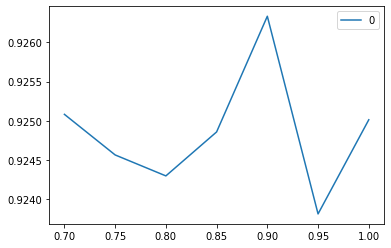

In [10]:
dfnest.plot()

In [13]:
x_train.columns

Index(['discount_rate', 'discount_type', 'discount_man', 'discount_jian',
       'Distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', '只领券',
       '核销数', '直接买', '单商铺最大购买次数', '成交商家数'],
      dtype='object')

In [14]:
dftest.columns

Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'discount_rate', 'discount_man', 'discount_jian',
       'discount_type', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', '用户id',
       '只领券', '核销数', '直接买', '单商铺最大购买次数', '成交商家数'],
      dtype='object')

# 提交

In [17]:
final_model = model_xgb()
last_features = preprocess.get_last_features(weekdaycols)
y_test_pred = final_model.predict_proba(dftest[last_features])
dftest1 = dftest[['User_id','Coupon_id','Date_received']].copy()
dftest1['label'] = y_test_pred[:,1]
dftest1.to_csv('submit_xgb.csv', index=False, header=False)


In [19]:
dftest[last_features]

,discount_rate,discount_type,discount_man,discount_jian,Distance,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,只领券,核销数,直接买,单商铺最大购买次数,成交商家数
0,0.833333,1,30,5,1,2,0,0,1,0,0,0,0,0,2.0,0.0,0.0,1.0,2.0
1,0.833333,1,30,5,2,3,0,0,0,1,0,0,0,0,0.0,1.0,1.0,2.0,1.0
2,0.900000,1,200,20,5,3,0,0,0,1,0,0,0,0,1.0,0.0,0.0,1.0,1.0
3,0.900000,1,100,10,5,3,0,0,0,1,0,0,0,0,1.0,0.0,0.0,1.0,1.0
4,0.966667,1,30,1,2,5,0,0,0,0,0,1,0,0,1.0,0.0,8.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113635,0.833333,1,30,5,10,6,1,0,0,0,0,0,1,0,2.0,0.0,0.0,1.0,2.0
113636,0.966667,1,30,1,2,4,0,0,0,0,1,0,0,0,2.0,1.0,0.0,1.0,3.0
113637,0.900000,1,50,5,2,2,0,0,1,0,0,0,0,0,2.0,1.0,0.0,1.0,3.0
113638,0.833333,1,30,5,0,7,1,0,0,0,0,0,0,1,3.0,1.0,2.0,2.0,5.0
